#Introduction to Machine Learning  
Computer Vision Hackathon  \
Gage DeZoort and Jon Halverson\
Princeton University Wintersession  \
January 22, 2024


This notebook trains a simple CNN on the MNIST dataset. The code comes from a [PyTorch example on GitHub](https://github.com/pytorch/examples/blob/master/mnist/main.py).

# About Your Colab Session

Learn about the CPU-cores for your session:

In [5]:
cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

In [6]:
import os
num_cores = min(os.cpu_count(), 2)
print(num_cores)

2


Let's see which GPU we are using (probably a Tesla T4):

In [7]:
!nvidia-smi

Tue Jan 23 05:01:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Data Preparation

Surprise! We're going to load up MNIST again :).

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from matplotlib import pyplot as plt

We want to use a GPU when one is available:

In [9]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [10]:
torch.manual_seed(42)
device = torch.device("cuda") if use_cuda else torch.device("cpu")

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': num_cores, 'pin_memory': True, 'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [11]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = datasets.MNIST('/tmp', train=True, download=True,
                       transform=transform)
test_data = datasets.MNIST('/tmp', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(test_data, **test_kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 100594023.85it/s]


Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31719218.07it/s]

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 8773795.17it/s]


Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15350949.85it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



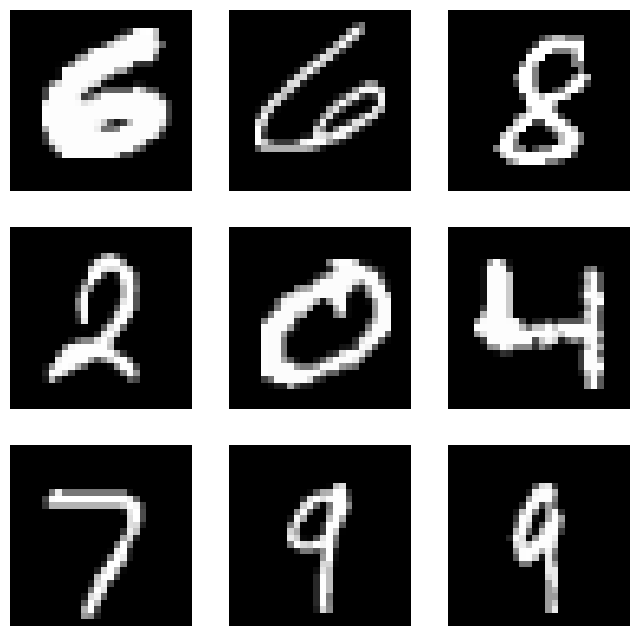

In [12]:
# plot several random examples
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Model Definition

Create a Python class called Net that derives from the nn.Module of PyTorch. The \_\_init__() method defines the network layers and regularization method while the forward method describes the forward pass.

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # first convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels=1,   # input image is greyscale, each pixel has 1 feature
            out_channels=32, # ask for 32 output features
            kernel_size=3,   # each filter is 3x3
            stride=1,        # slide the filters pixel-by-pixel across the image
        )

        # second convolutional layer
        self.conv2 = nn.Conv2d(
            in_channels=32,  # we have 32 feature maps (26x26x32) from the last Conv2d
            out_channels=64, # ask for 64 output features
            kernel_size=3,   # each filter is 3x3x32
            stride=1,        # slide the filters without making jumps
        )

        # dropout randomly "drops out" a tensor so that the model doesn't overtrain
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # flattened images after pooling, 12x12x64=9216
        self.fc1 = nn.Linear(
            in_features=9216,
            out_features=128
        )
        self.fc2 = nn.Linear(
            in_features=128,
            out_features=10
        )

    def forward(self, x):
        # apply convolutional layers
        x = self.conv1(x)
        # input images are (batch_size, 1, 28, 28)
        # (1 input feature) x (32 output features) = 32 filters
        # each 3x3 filter reduces the pixel dimensions from (28,28) to (26, 26)
        # at output we expect (batch_size, 32, 26, 26)
        x = F.relu(x)
        x = self.conv2(x)
        # output from conv1 has shape (batch_size, 32, 26, 26)
        # (32 input features) x (64 output features) = 2048 filters created
        # each 3x3 filter reduces te pixel dimensions from (26,26) to (24,24)
        # at output we expect (batch_size, 64, 24, 24)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # maxpooling operator with kernel_size=stride=2
        # reduces the pixel dimensions to (24/2, 24/2) = (12, 12)
        # at output we expect (batch_size, 64, 12, 12)
        x = self.dropout1(x)
        # flatten and feed to a NN
        x = torch.flatten(x, 1)
        # 64x12x12=9216 features fed to fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1) # log_softmax + nll_loss = cross entropy loss
        return output

Instantiate the network and move it to the device (which is a GPU when available). Create the optimizer.

In [14]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

In [15]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
           Dropout-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------


# Train and Test Methods

In [16]:
def train(model, device, train_loader, optimizer, epoch):
    model.train() # sets the model in training mode (i.e., dropout enabled)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [17]:
def test(model, device, test_loader):
    model.eval() # sets the model in evaluation mode (i.e., dropout disabled)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train for some number of epochs while reporting the accuracy on the test set periodically:

In [18]:
epochs = 5
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303002
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.235444
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.093324
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.091235
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.174501
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.037191
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.172091
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.090374
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.115071
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.135946

Test set: Average loss: 0.0423, Accuracy: 9854/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.083882
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.070705
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.003522
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.038864
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.063291
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.015491
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.114971
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.231971
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.020442
T